# 3.3. Find Balance of Friction with Static Analysis



In [1]:
%config InlineBackend.figure_format = "svg"
import numpy as np
from matplotlib import pyplot as plt
import sys
import pathlib
import os
sys.path.append(str(pathlib.Path(os.path.abspath('')).resolve().parent.parent))

from _9_Mechanics.Spiral import Spiral
from _9_Mechanics.Tribology import Tribology

TB = Tribology()


## 3.2.1. Optimal Mesh Number

### 3.2.1.1. Optimal Ratio of $r$ and $\theta$




In [2]:
R = 6.35 / 2
Rg = R * 1.08
ts = 45
tn = 45
dRs0 = R * 0.08 * np.cos(np.deg2rad(ts))
dRs1 = R * 0.08 * np.sin(np.deg2rad(ts))
dRn0 = R * 0.08 * np.cos(np.deg2rad(tn))
dRn1 = R * 0.08 * np.sin(np.deg2rad(tn))
PCR = 20.875
l = 10.0

SP1 = Spiral(alp=np.deg2rad(1e-1), l=l, r=PCR, eta=np.array([[-dRs0, -dRs1],[-dRs0, dRs1]]), R=np.array([Rg, Rg]))
SP2 = Spiral(alp=np.deg2rad(-1e-1), l=l, r=PCR, eta=np.array([[dRn0, -dRn1],[dRn0, dRn1]]), R=np.array([Rg, Rg]))
SP12 = [SP1, SP2]

rho = 7.9e-3 # [g/mm^3]
Ball_m = 4/3 * np.pi * R**3 * rho # [g]
Ball_I = 2/5 * Ball_m * R**2 # [g * mm^2]
Ball_r_inv = 1.0 / R
zeta = 0.2
E_Reduced = 231e3 # [N/mm^2]
rpm = 1000
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
mu = 0.10


In [3]:
def get_mesh(n_r, n_t):
    OffbyOne = lambda n : (np.arange(n) + 0.5) / n

    r = OffbyOne(n_r)
    t = OffbyOne(n_t) * 2 * np.pi

    r_, t_ = np.meshgrid(r, t)
    x_ = r_ * np.cos(t_) * 2.0 # = a 
    y_ = r_ * np.sin(t_) * 1.0 # = b
    F_ = np.sqrt(1 - np.square(r_))

    dt = t[1] - t[0]
    r_node = np.linspace(0., 1., n_r+1)
    Antiderivative = lambda x: -(1-x*x)**1.5 / 2 / np.pi
    ratio_dt = (Antiderivative(r_node[1:]) - Antiderivative(r_node[:-1])) * dt

    r_, t_ = np.meshgrid(r, t)
    ratio, t_ = np.meshgrid(ratio_dt, t)

    r_mesh = r_.reshape(-1)
    t_mesh = t_.reshape(-1)
    ratio_mesh = ratio.reshape(-1)
    x_mesh = r_mesh * np.cos(t_mesh)
    y_mesh = r_mesh * np.sin(t_mesh)
    return r_mesh, t_mesh, ratio_mesh, x_mesh, y_mesh


In [4]:
def Make_Matrix(a, b):
    return a.reshape(-1, 1) @ b.reshape(1, -1)

def vFmTI_ball(xvw_ball, t, mode):
    
    x_ball = xvw_ball[0:3]
    v_ball = xvw_ball[3:6]
    w_ball = xvw_ball[6:9]
    
    Zeros = np.zeros(3)
    vr = np.linalg.norm(v_ball)
    x_square = np.square(x_mesh)
    y_square = np.square(y_mesh)
    
    dx      = np.zeros([2, 2])
    k_      = dx.copy()
    a_      = dx.copy()
    b_      = dx.copy()
    v_      = dx.copy()
    F_norm  = dx.copy()

    cos_sin   = np.zeros([2, 2, 2])
    SP_r_inv  = cos_sin.copy()
    R_Reduced = cos_sin.copy()
    parabola  = cos_sin.copy()
    
    exyz    = np.zeros([2, 2, 3])
    F_      = exyz.copy()
    a_dir   = exyz.copy()
    peak    = exyz.copy()
    
    eta   = np.zeros([2, 3])
    b_dir = eta.copy()
    v_eta = eta.copy()
    
    xyz2eta = np.zeros([2, 3, 3])
    
    n_mesh = len(x_mesh)
    F_mesh = np.zeros([2, 2, n_mesh])
    
    p_mesh = np.zeros([2, 2, n_mesh, 3])
    SP_v   = p_mesh.copy()
    BL_v   = p_mesh.copy()
    dv     = p_mesh.copy()
    muT    = p_mesh.copy()

    v_dir = np.zeros([2, 2, 3, n_mesh])
    muF   = v_dir.copy()
    
    for iSP, SP in enumerate(SP12):
        
        eta[iSP,:] = SP.to_eta2(x_ball)
        xyz2eta[iSP,:,:] = SP.get_xyz2eta(eta[iSP,0])
        b_dir[iSP,:] = xyz2eta[iSP,:,:].T @ np.array([1.0, 0.0, 0.0])
        v_eta[iSP,:] = xyz2eta[iSP,:,:] @ v_ball

        for i in range(2):
            cos_sin[iSP,i], dx[iSP,i], exyz[iSP,i,:] = SP.get_contact(x_ball, R, i)
            if dx[iSP,i] > 0:
                SP_r_inv[iSP,i,:] = SP.get_rho(cos_sin[iSP,i,0], i)
                R_Reduced[iSP,i,:] = 1.0 / (Ball_r_inv + SP_r_inv[iSP,i,:])
                k_[iSP,i], a_[iSP,i], b_[iSP,i] = TB.BrewHamrock(R_Reduced[iSP,i,0], R_Reduced[iSP,i,1], dx[iSP,i], E_Reduced)
                v_[iSP,i] = v_ball.dot(exyz[iSP,i,:])
                F_norm[iSP,i] = TB.Tsuji(k_[iSP,i], zeta, Ball_m, v_[iSP,i], dx[iSP,i])
                F_[iSP,i,:] = - F_norm[iSP,i] * exyz[iSP,i,:]

                a_dir[iSP,i,:] = - np.cross(b_dir[iSP,:], exyz[iSP,i,:])
                
                peak[iSP,i,:] = x_ball + (R - dx[iSP,i] / 2) * exyz[iSP,i,:]
                for j in range(2):
                    parabola[iSP,i,j] = TB.Parabola(Ball_r_inv, SP_r_inv[iSP,i,j], dx[iSP,i])
                
                p_mesh[iSP,i,:,:] = peak[iSP,i,:] + Make_Matrix(a_[iSP,i] * x_mesh, a_dir[iSP,i,:]) + Make_Matrix(b_[iSP,i] * y_mesh, b_dir[iSP,:]) + Make_Matrix(parabola[iSP,i,1] * np.square(a_[iSP,i]) * x_square - parabola[iSP,i,0] * np.square(b_[iSP,i]) * y_square, -exyz[iSP,i,:])
                F_mesh[iSP,i,:] = F_norm[iSP,i] * ratio_mesh
                
                SP_v[iSP,i,:,:]  = TB.surface_velocity(Zeros, p_mesh[iSP,i,:,:], v12[iSP], w12[iSP])
                BL_v[iSP,i,:,:]  = TB.surface_velocity(x_ball, p_mesh[iSP,i,:,:], v_ball, w_ball)
                dv[iSP,i,:,:]    = SP_v[iSP,i,:,:] - BL_v[iSP,i,:,:]
                v_dir[iSP,i,:,:] = dv[iSP,i,:,:].T * (1 / np.sqrt(np.square(dv[iSP,i,:,:]).sum(1)))
                muF[iSP,i,:,:] = F_mesh[iSP,i,:] * v_dir[iSP,i,:,:] * mu
                muT[iSP,i,:,:] = TB.calc_Torque(x_ball, p_mesh[iSP,i,:,:], muF[iSP,i,:,:].T)
                
    Fm_ball = (F_.sum(0).sum(0) + muF.sum(0).sum(0).sum(1)) / Ball_m * 1e6
    TI_ball = (muT.sum(0).sum(0).sum(0)) / Ball_I * 1e6
    
    if mode == 1:
        return a_, b_, a_dir, b_dir, dv

    if mode == 2:
        return a_, b_, a_dir, b_dir, muF, F_norm
    
    if mode == 3:
        return v_eta
    
    if mode == 4:
        return p_mesh
    
    if mode == 5:
        return muF, muT

    return np.concatenate([v_ball, Fm_ball, TI_ball])



In [5]:
xvw_ball = np.array([ 7.49214529e-01,  1.86156547e+01,  9.44934733e+00,  7.47973408e+01, -4.44066650e+02,  8.74837953e+02, -3.34519496e+02, -1.05000027e+02, -2.09607491e+01])


In [6]:
n_r = 1000
n_t = 1000

r_mesh, t_mesh, ratio_mesh, x_mesh, y_mesh = get_mesh(n_r, n_t)
muF, muT = vFmTI_ball(xvw_ball, 0, 5)

muF_true = muF[0,0].sum(1)
muT_true = muT[0,0].sum(0)

muF_true_norm = np.linalg.norm(muF[0,0].sum(1))
muT_true_norm = np.linalg.norm(muT[0,0].sum(0))


In [7]:
import warnings
warnings.filterwarnings('ignore')

def plot_t_r_mesh(n):
    global r_mesh, t_mesh, ratio_mesh, x_mesh, y_mesh

    def r2t(r):
        return (2**n / r * 2).astype(int)
    
    muF_array = np.zeros(n)
    muT_array = np.zeros(n)
    n_r_array = np.power(2, np.arange(n)+1).astype(int)
    n_t_array = (2**n / n_r_array * 2).astype(int)

    for i in range(n):

        n_r = n_r_array[i]
        n_t = n_t_array[i]

        r_mesh, t_mesh, ratio_mesh, x_mesh, y_mesh = get_mesh(n_r, n_t)
        muF, muT = vFmTI_ball(xvw_ball, 0, 5)

        muF_array[i] = np.linalg.norm(muF_true - muF[0,0].sum(1))
        muT_array[i] = np.linalg.norm(muT_true - muT[0,0].sum(0))
        
    fig, ax = plt.subplots(1)
    ax.loglog(n_t_array, muF_array/muF_true_norm, n_t_array, muT_array/muT_true_norm)
    ax.set_xticks(n_t_array)
    ax.set_xticklabels(n_t_array.astype(str))
    ax.set_xlabel('t mesh num [-]')

    secax = ax.secondary_xaxis('top', functions=(r2t, r2t))
    secax.set_xticks(n_r_array)
    secax.set_xticklabels(n_r_array.astype(str))
    secax.set_xlabel('r mesh num [-]')

    return fig, ax
    

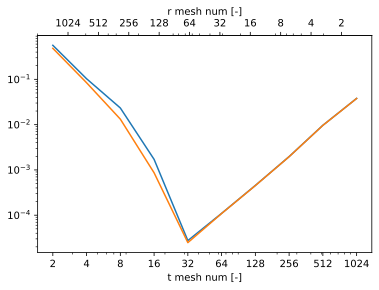

In [8]:
fig, ax = plot_t_r_mesh(10)
fig.show()


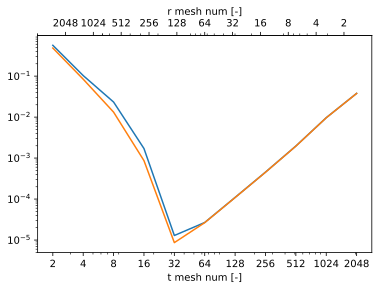

In [9]:
fig, ax = plot_t_r_mesh(11)
fig.show()


[3042 3072 3051]


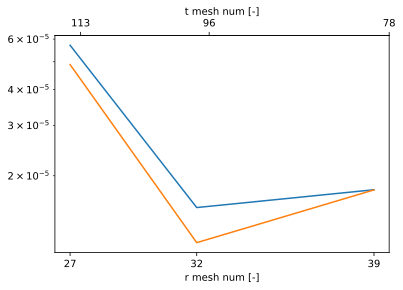

In [10]:
n = 3
hoge = 16

def r2t(r):
    return (hoge**2*12 / r).astype(int)

muF_array = np.zeros(n)
muT_array = np.zeros(n)
n_t_array = (np.sqrt(np.array([6,4,3]))*hoge).astype(int)
n_r_array = r2t(n_t_array)

print(n_r_array * n_t_array)

for i in range(n):

    n_r = n_r_array[i]
    n_t = n_t_array[i]

    r_mesh, t_mesh, ratio_mesh, x_mesh, y_mesh = get_mesh(n_r, n_t)
    muF, muT = vFmTI_ball(xvw_ball, 0, 5)

    muF_array[i] = np.linalg.norm(muF_true - muF[0,0].sum(1))
    muT_array[i] = np.linalg.norm(muT_true - muT[0,0].sum(0))
    
fig, ax = plt.subplots(1)
ax.semilogy(n_t_array, muF_array/muF_true_norm, n_t_array, muT_array/muT_true_norm)
ax.set_xticks(n_t_array)
ax.set_xticklabels(n_t_array.astype(str))
ax.set_xlabel('r mesh num [-]')

secax = ax.secondary_xaxis('top', functions=(r2t, r2t))
secax.set_xticks(n_r_array)
secax.set_xticklabels(n_r_array.astype(str))
secax.set_xlabel('t mesh num [-]')

fig.show()


In [25]:
def plot_t_3t_mesh(n_t_array):
    global r_mesh, t_mesh, ratio_mesh, x_mesh, y_mesh
    
    n = len(n_t_array)

    muF_array = np.zeros(n)
    muT_array = np.zeros(n)
    n_r_array = n_t_array * 3

    for i in range(n):

        n_r = n_r_array[i]
        n_t = n_t_array[i]

        r_mesh, t_mesh, ratio_mesh, x_mesh, y_mesh = get_mesh(n_r, n_t)
        muF, muT = vFmTI_ball(xvw_ball, 0, 5)

        muF_array[i] = np.linalg.norm(muF_true - muF[0,0].sum(1))
        muT_array[i] = np.linalg.norm(muT_true - muT[0,0].sum(0))

    def r2t_(r):
        return r * 3

    def t2r_(t):
        return t / 3

    fig, ax = plt.subplots(1)
    ax.semilogy(n_t_array, muF_array/muF_true_norm, n_t_array, muT_array/muT_true_norm)
    ax.set_xticks(n_t_array)
    ax.set_xticklabels(n_t_array.astype(str))
    ax.set_xlabel('t mesh num [-]')

    secax = ax.secondary_xaxis('top', functions=(r2t_, t2r_))
    secax.set_xticks(n_r_array)
    secax.set_xticklabels(n_r_array.astype(str))
    secax.set_xlabel('r mesh num [-]')
    
    return fig, ax

    

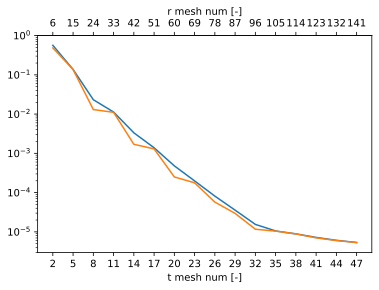

In [26]:
n_t_array = np.linspace(2, 47, 16).astype(int)
fig, ax = plot_t_3t_mesh(n_t_array)


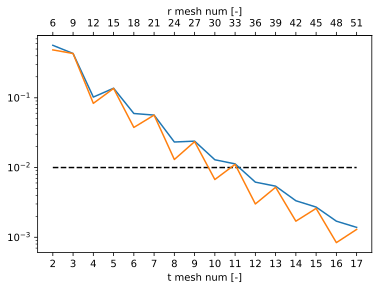

In [37]:
n_t_array = np.arange(2, 18).astype(int)
fig, ax = plot_t_3t_mesh(n_t_array)
ax.hlines([1e-2], n_t_array[0], n_t_array[-1], color='k', ls='--')
